In [6]:
from collections import Counter
import pandas as pd
import numpy as np
import random # random number/seed
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import math
import sympy as sy # equation solver
import seaborn as sns # heatmap
import time # timestamp
import scipy.stats as stats

# Generate and plot a synthetic imbalanced classification dataset
# ML setup
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# ML metrics and curves
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve

#imputation and feature scaling
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import PercentFormatter

#shap values
# import shap
from scipy.spatial import ConvexHull
from ClinicalUtilityProfiling import *
from sklearn.metrics import roc_curve, auc as calculate_auc  # Renaming the imported auc function
import json

from scipy.spatial.distance import cdist


def cleanThresholds(array_thresholds):
    #replace inf and -inf
    for i, value in enumerate(array_thresholds):
        if value == math.inf or value > 1:
            array_thresholds[i] = 1
        elif value == -math.inf or value < 0:
            array_thresholds[i] = 0

    return array_thresholds

def gnumeric_func(data, columns):
    data[columns] = data[columns].apply(lambda x: pd.factorize(x, sort=True)[0])
    return data

def compute_percentiles(df):
    percentiles = df.apply(lambda x: pd.Series({
        '2.5th Percentile': np.percentile(x, 2.5),
        '97.5th Percentile': np.percentile(x, 97.5)
    }))
    return percentiles

In [7]:
data = pd.read_csv('medicalDatasets/diabetes/diabetes.csv')  
data = data.rename(columns={ "Outcome": "y"})
colnames = data.columns[0:data.shape[1]-1]

numericColumnsWMissing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                          'Age', 'BMI', 'DiabetesPedigreeFunction']
data = gnumeric_func(data, numericColumnsWMissing)
data[numericColumnsWMissing] = data[numericColumnsWMissing].apply(lambda x: np.where(x == 0, np.NaN, x ))

data = pd.DataFrame(data).values
ix = [i for i in range(data.shape[1]) if i != 8]
X, y = data[:, ix], data[:, 8]
# print total missing
print('Missing: %d' % sum(pd.isnull(X).flatten()))

# define imputer, fit, and transform
imputer = KNNImputer()
imputer.fit(X)
Xtrans = imputer.transform(X)

# print total missing
print('Missing: %d' % sum(pd.isnull(Xtrans).flatten()))
Xs = pd.DataFrame(Xtrans, columns = colnames)
Y = pd.DataFrame(y, columns = ['y'])
data = pd.concat([Xs, Y], axis=1)

Xs = np.array(data.iloc[:,0:(data.shape[1]-1)])
Y = np.array(data['y'])
data

Missing: 716
Missing: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,y
0,6.0,86.0,22.0,28.0,105.2,123.0,350.0,29.0,1.0
1,1.0,23.0,19.0,22.0,26.0,62.0,196.0,10.0,0.0
2,8.0,121.0,17.0,18.6,88.8,30.0,368.0,11.0,1.0
3,1.0,27.0,19.0,16.0,62.0,77.0,53.0,9.8,0.0
4,0.0,75.0,4.0,28.0,102.0,209.0,514.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,39.0,25.0,41.0,108.0,118.0,55.0,42.0,0.0
764,2.0,60.0,21.0,20.0,70.2,155.0,187.0,6.0,0.0
765,5.0,59.0,22.0,16.0,71.0,58.0,115.0,9.0,0.0
766,1.0,64.0,14.0,21.6,73.6,95.0,195.0,26.0,1.0


In [8]:
def bayesian_bootstrap(X, y, n_iterations=1000):
    n = len(y)
    bootstrapped_X = []
    bootstrapped_y = []
    
    for _ in range(n_iterations):
        # Sample weights from a Dirichlet distribution
        weights = np.random.dirichlet(np.ones(n))
        indices = np.random.choice(np.arange(n), size=n, replace=True, p=weights)
        bootstrapped_X.append(X[indices])
        bootstrapped_y.append(y[indices])
    
    return np.array(bootstrapped_X), np.array(bootstrapped_y)

# Apply Bayesian bootstrap to the dataset
bootstrapped_X, bootstrapped_y = bayesian_bootstrap(Xs, Y, n_iterations=len(Y))

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

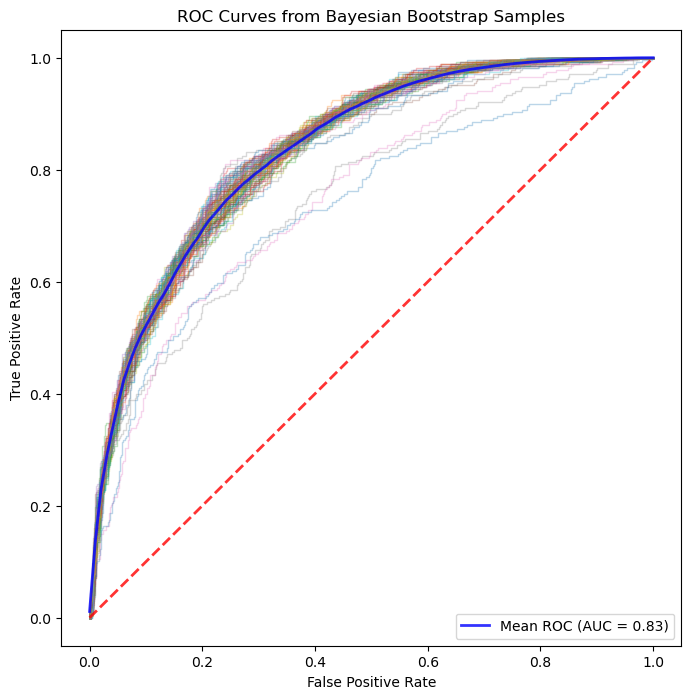

Mean AUC: 0.8343
Standard deviation of AUC: 0.0163


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Initialize lists to store AUC scores, TPRs, and FPRs
auc_scores = []
tpr_list = []
fpr_list = []

for i in range(100):
    # Train logistic regression on the i-th bootstrapped sample
    model = LogisticRegression()
    model.fit(bootstrapped_X[i], bootstrapped_y[i])
    
    # Compute the ROC curve and AUC score
    y_pred_proba = model.predict_proba(Xs)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
    # Store the TPR and FPR
    tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))
    fpr_list.append(np.linspace(0, 1, 100))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3)

# Compute average TPR and FPR
mean_tpr = np.mean(tpr_list, axis=0)
mean_fpr = np.mean(fpr_list, axis=0)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {np.mean(auc_scores):.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

plt.title('ROC Curves from Bayesian Bootstrap Samples')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Display summary statistics for AUC scores
print(f"Mean AUC: {np.mean(auc_scores):.4f}")
print(f"Standard deviation of AUC: {np.std(auc_scores):.4f}")


In [26]:
pDisease = 0.5
dU = 0
# uTPs = np.arange(0, 1.05, 0.05)
uTPs = [0.8]
# model_idx = 1
HoverBs = []
HoverBs = np.append(HoverBs, np.arange(0.01, 2.5, 0.01))
# HoverBs = np.append(HoverBs, np.arange(2.5, 100, 0.1))
# HoverBs = np.append(HoverBs, np.arange(100, 1000, 10))
# HoverBs = np.append(HoverBs, np.arange(0, 1.0/uTPs[0], 0.01))
maxEUs, pLs, pUs, prob_cutoffs = cup(pDisease, mean_fpr, mean_tpr, thresholds, HoverBs, uTPs, dU)
# Interpolating Z values onto a grid
X, Y = np.meshgrid(uTPs, HoverBs)
# Z, Z1, Z2 = cup(pDisease, fprs, tprs, costRatios, uTPs, dU)
Z1 = maxEUs.reshape(len(uTPs), len(HoverBs))
Z2 = pLs.reshape(len(uTPs), len(HoverBs))
Z3 = pUs.reshape(len(uTPs), len(HoverBs))
Z4 = prob_cutoffs.reshape(len(uTPs), len(HoverBs))
priorRange = pUs - pLs
priorRange = np.array([x if x >= 0 else 0 for x in priorRange])
Z5 = priorRange.reshape(len(uTPs), len(HoverBs))

0.8
Took:  16.4374258518219  seconds.


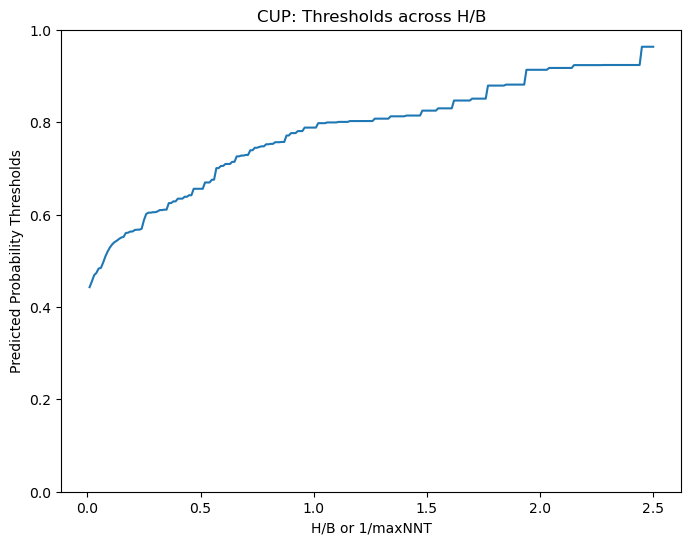

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(HoverBs, prob_cutoffs)  # 'marker=o' adds a circle marker at each data point

# Adding title and labels
plt.title('CUP: Thresholds across H/B')
plt.xlabel('H/B or 1/maxNNT')
plt.ylabel('Predicted Probability Thresholds')
# Show the plot
plt.ylim([0.0, 1.0])
plt.show()

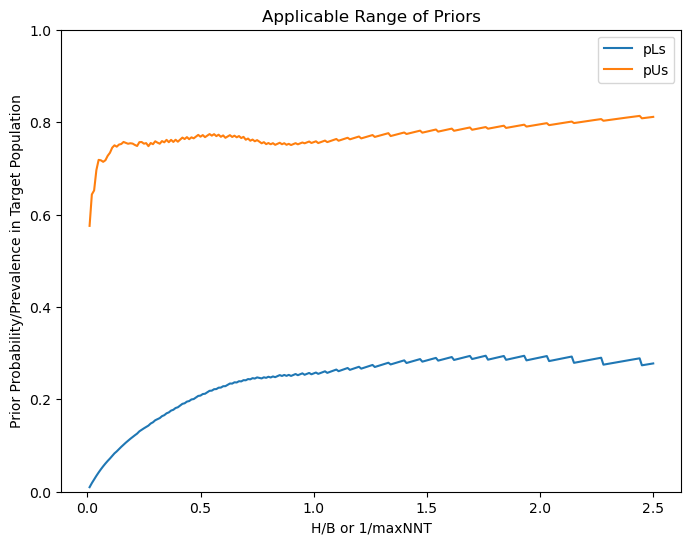

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(HoverBs, pLs, label='pLs')  # 'marker=o' adds a circle marker at each data point
plt.plot(HoverBs, pUs, label='pUs')  # 'marker=o' adds a circle marker at each data point
# Adding title and labels
plt.title('Applicable Range of Priors')
plt.xlabel('H/B or 1/maxNNT')
plt.ylabel('Prior Probability/Prevalence in Target Population')
plt.legend()
plt.ylim([0.0, 1.0])
# Show the plot
plt.show()

/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])


Took:  3.5849368572235107  seconds.


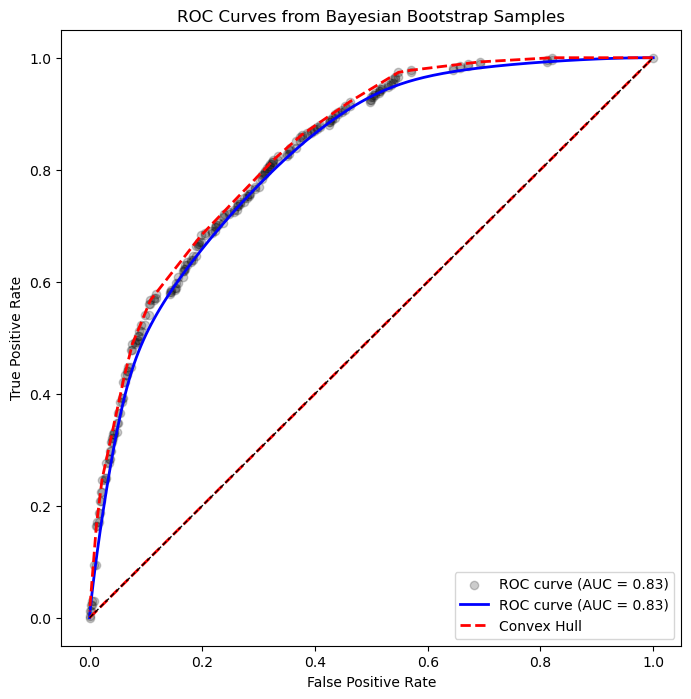

Mean AUC: 0.8335
Standard deviation of AUC: 0.0000


In [19]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import pandas as pd

sample_size = len(Y)
slope_of_interest = 2

# Initialize a list to store AUC scores
auc_scores = []

# Initialize lists to store results
auc_scores = []
closest_prob_cutoffs = []
original_fprs = []
original_tprs = []
closest_fprs = []
closest_tprs = []
closest_npvs = []
closest_ppvs = []

plt.figure(figsize=(8, 8))

start = time.time()

for i in range(1):
    # Train logistic regression on the i-th bootstrapped sample
    model = LogisticRegression()
    model.fit(bootstrapped_X[i], bootstrapped_y[i])
    
    # Compute the ROC curve and AUC score
    y_pred_proba = model.predict_proba(Xs)[:, 1]
    fprs, tprs, proba_cutoff = roc_curve(y, y_pred_proba)
    roc_auc = auc(fprs, tprs)
    auc_scores.append(roc_auc)
    
    #bezier
    outer_idx = max_relative_slopes(fprs, tprs)[1]
    
    outer_idx = clean_max_relative_slope_index(outer_idx, len(tprs))
    u_roc_fpr_fitted, u_roc_tpr_fitted = fprs[outer_idx], tprs[outer_idx]
    u_roc_fpr_fitted, u_roc_tpr_fitted = deduplicate_roc_points(u_roc_fpr_fitted, u_roc_tpr_fitted)

    #general rational bezier fit
    control_points = list(zip(u_roc_fpr_fitted, u_roc_tpr_fitted))
    empirical_points = list(zip(fprs, tprs))
    initial_weights = [1] * len(control_points)
    bounds = [(0, 20) for _ in control_points]
    # Optimize weights to fit the empirical points
    result = minimize(error_function, initial_weights, args=(control_points, empirical_points), method='SLSQP', bounds = bounds)
    optimal_weights = result.x

    # Compute the rational Bezier curve with optimal weights
    curve_points = rational_bezier_curve(control_points, optimal_weights)
    cutoff_rational = find_fpr_tpr_for_slope(curve_points, slope_of_interest)

    closest_fpr, closest_tpr = cutoff_rational[0], cutoff_rational[1]
    #find the closest pair of tpr and fpr from the original arrays
    original_tpr, original_fpr, index = find_closest_pair_separate(tprs, fprs, closest_tpr, closest_fpr)
    closest_prob_cutoff = proba_cutoff[index]
    
    # Find the closest probability cutoff (using the point with maximum TPR)
    closest_prob_cutoff = proba_cutoff[index]

    # Compute PPV and NPV for the closest probability cutoff
    y_pred = (y_pred_proba >= closest_prob_cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    closest_ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    closest_npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    closest_prob_cutoffs.append(closest_prob_cutoff)
    original_fprs.append(original_fpr)
    original_tprs.append(original_tpr)
    closest_fprs.append(closest_fpr)
    closest_tprs.append(closest_tpr)
    closest_ppvs.append(closest_ppv)
    closest_npvs.append(closest_npv)
    
    # Plot the ROC curve
    plt.scatter(fprs, tprs, lw=1, alpha=0.2, color = 'black', label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")
    plt.plot(curve_points[:, 0], curve_points[:, 1], lw=2, alpha=1, color = 'blue', label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")

# Calculate and plot the convex hull (only once)
points = np.column_stack((fprs, tprs))
hull = ConvexHull(points)
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'r--', lw=2, label='Convex Hull')


end = time.time()
print("Took: ", end-start, " seconds.")

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=1)

plt.title('ROC Curves from Bayesian Bootstrap Samples')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Display summary statistics for AUC scores
print(f"Mean AUC: {np.mean(auc_scores):.4f}")
print(f"Standard deviation of AUC: {np.std(auc_scores):.4f}")

# Output the results
results_df = pd.DataFrame({
    'Closest Prob Cutoff': closest_prob_cutoffs,
    'originalFPR': original_fprs,
    'originalTPR': original_tprs,
    'fittedFPR': closest_fprs,
    'fittedTPR': closest_tprs,
    'NPV': closest_npvs,
    'PPV': closest_ppvs
})

# import ace_tools as tools; tools.display_dataframe_to_user(name="Bayesian Bootstrap Results", dataframe=results_df)


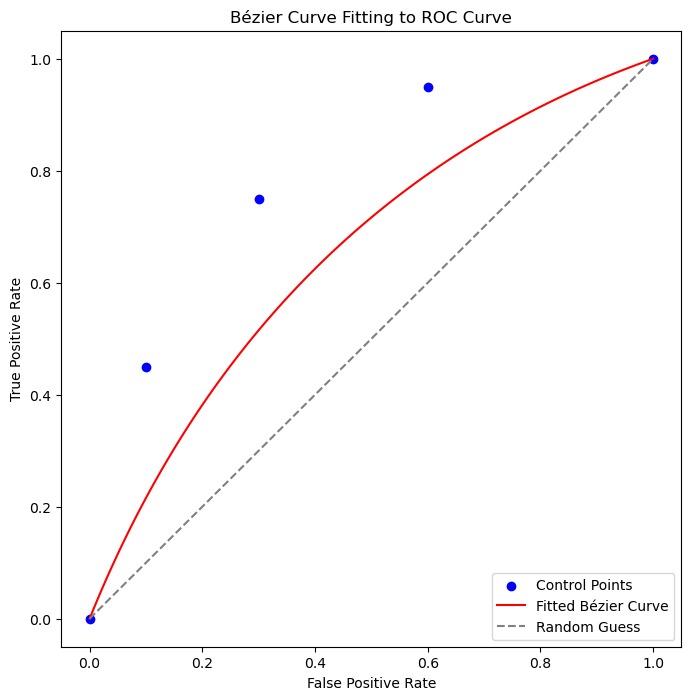

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated ROC data (5 points)
fprs = np.array([0.0, 0.1, 0.3, 0.6, 1.0])
tprs = np.array([0.0, 0.45, 0.75, 0.95, 1.0])

# Define the quadratic Bézier curve function
def bezier_curve(t, control_points):
    p0, p1, p2 = control_points
    p0 = np.array(p0)
    p1 = np.array(p1)
    p2 = np.array(p2)
    return (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2

# Use the original points as control points
control_points = [(fprs[0], tprs[0]), (fprs[2], tprs[2]), (fprs[-1], tprs[-1])]

# Generate the fitted Bézier curve points
t_values = np.linspace(0, 1, 100)
bezier_points = np.array([bezier_curve(t, control_points) for t in t_values])

# Plot the original ROC points and the fitted Bézier curve
plt.figure(figsize=(8, 8))
plt.scatter(fprs, tprs, color='blue', label='Control Points')
plt.plot(bezier_points[:, 0], bezier_points[:, 1], color='red', label='Fitted Bézier Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bézier Curve Fitting to ROC Curve')
plt.legend(loc='lower right')
plt.show()


/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:282: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (tprs[j] - tprs[i]) / (fprs[j] - fprs[i])
/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Dr. Harold Lehmann/Code/New Approach/ClinicalUtilityProfiling.py:533: RuntimeWarning: invalid value encountered in divide
  curve_point

Took:  199.5724060535431  seconds.


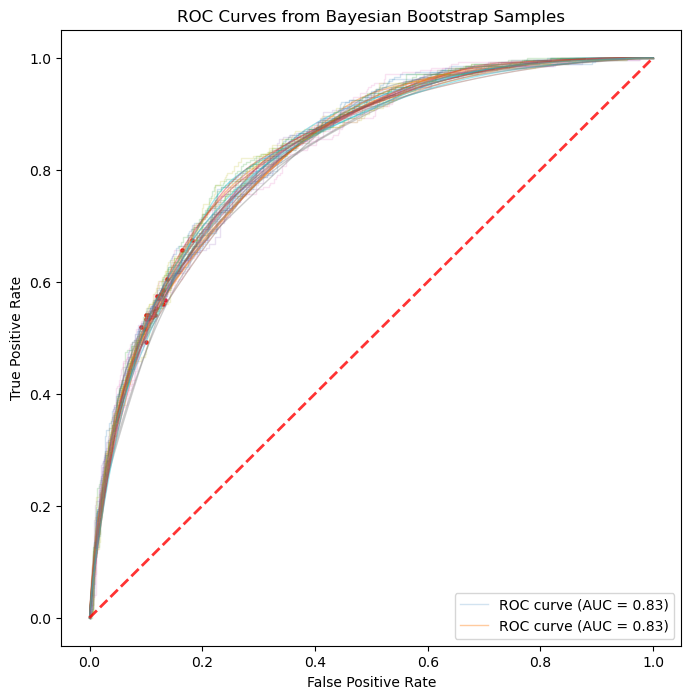

Mean AUC: 0.8348
Standard deviation of AUC: 0.0040


In [5]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

sample_size = 20#len(Y)
slope_of_interest = 2

# Initialize a list to store AUC scores
auc_scores = []

# Initialize lists to store results
auc_scores = []
closest_prob_cutoffs = []
original_fprs = []
original_tprs = []
closest_fprs = []
closest_tprs = []
closest_npvs = []
closest_ppvs = []

plt.figure(figsize=(8, 8))

start = time.time()

for i in range(sample_size):
    # Train logistic regression on the i-th bootstrapped sample
    model = LogisticRegression()
    model.fit(bootstrapped_X[i], bootstrapped_y[i])
    
    # Compute the ROC curve and AUC score
    y_pred_proba = model.predict_proba(Xs)[:, 1]
    fprs, tprs, proba_cutoff = roc_curve(y, y_pred_proba)
    roc_auc = auc(fprs, tprs)
    auc_scores.append(roc_auc)
    
    #bezier
    outer_idx = max_relative_slopes(fprs, tprs)[1]
    
    outer_idx = clean_max_relative_slope_index(outer_idx, len(tprs))
    u_roc_fpr_fitted, u_roc_tpr_fitted = fprs[outer_idx], tprs[outer_idx]
    u_roc_fpr_fitted, u_roc_tpr_fitted = deduplicate_roc_points(u_roc_fpr_fitted, u_roc_tpr_fitted)

    #general rational bezier fit
    control_points = list(zip(u_roc_fpr_fitted, u_roc_tpr_fitted))
    empirical_points = list(zip(fprs, tprs))
    initial_weights = [1] * len(control_points)
    bounds = [(0, 20) for _ in control_points]
    # Optimize weights to fit the empirical points
    result = minimize(error_function, initial_weights, args=(control_points, empirical_points), method='SLSQP', bounds = bounds)
    optimal_weights = result.x

    # Compute the rational Bezier curve with optimal weights
    curve_points = rational_bezier_curve(control_points, optimal_weights)
    cutoff_rational = find_fpr_tpr_for_slope(curve_points, slope_of_interest)

    closest_fpr, closest_tpr = cutoff_rational[0], cutoff_rational[1]
    #find the closest pair of tpr and fpr from the original arrays
    original_tpr, original_fpr, index = find_closest_pair_separate(tprs, fprs, closest_tpr, closest_fpr)
    closest_prob_cutoff = proba_cutoff[index]
    
    # Find the closest probability cutoff (using the point with maximum TPR)
    closest_prob_cutoff = proba_cutoff[index]

    # Compute PPV and NPV for the closest probability cutoff
    y_pred = (y_pred_proba >= closest_prob_cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    closest_ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    closest_npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    closest_prob_cutoffs.append(closest_prob_cutoff)
    original_fprs.append(original_fpr)
    original_tprs.append(original_tpr)
    closest_fprs.append(closest_fpr)
    closest_tprs.append(closest_tpr)
    closest_ppvs.append(closest_ppv)
    closest_npvs.append(closest_npv)
    
    # Plot the ROC curve
    plt.plot(fprs, tprs, lw=1, alpha=0.2, label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")
    plt.plot(curve_points[:, 0], curve_points[:, 1], lw=1, alpha=0.4, label=f'ROC curve (AUC = {roc_auc:.2f})' if i == 0 else "")
    plt.scatter([original_fpr], [original_tpr], color='red', s=5, alpha=1)

end = time.time()
print("Took: ", end-start, " seconds.")

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

plt.title('ROC Curves from Bayesian Bootstrap Samples')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Display summary statistics for AUC scores
print(f"Mean AUC: {np.mean(auc_scores):.4f}")
print(f"Standard deviation of AUC: {np.std(auc_scores):.4f}")

# Output the results
import pandas as pd
results_df = pd.DataFrame({
    'Closest Prob Cutoff': closest_prob_cutoffs,
    'originalFPR': original_fprs,
    'originalTPR': original_tprs,
    'fittedFPR': closest_fprs,
    'fittedTPR': closest_tprs,
    'NPV': closest_npvs,
    'PPV': closest_ppvs
})

# import ace_tools as tools; tools.display_dataframe_to_user(name="Bayesian Bootstrap Results", dataframe=results_df)


In [22]:
json_file_path = 'Results/bayesian_bootstrap_pima_results070624_slope2.json'
results_df.to_json(json_file_path, orient='records', lines=False)

In [23]:
results_df.describe()

,Closest Prob Cutoff,originalFPR,originalTPR,fittedFPR,fittedTPR,NPV,PPV
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.531583,0.117172,0.551743,0.121186,0.549734,0.786490,0.717851
std,0.058080,0.019363,0.042141,0.018595,0.042124,0.012748,0.022406
min,0.343714,0.068000,0.268657,0.071287,0.266190,0.703927,0.624390
25%,0.493751,0.102000,0.526119,0.108324,0.523837,0.778929,0.702495
50%,0.534365,0.116000,0.552239,0.119553,0.547969,0.786029,0.718002
75%,0.569786,0.130000,0.578358,0.132903,0.576324,0.794171,0.732634
max,0.715303,0.174000,0.660448,0.173547,0.662032,0.822957,0.779762


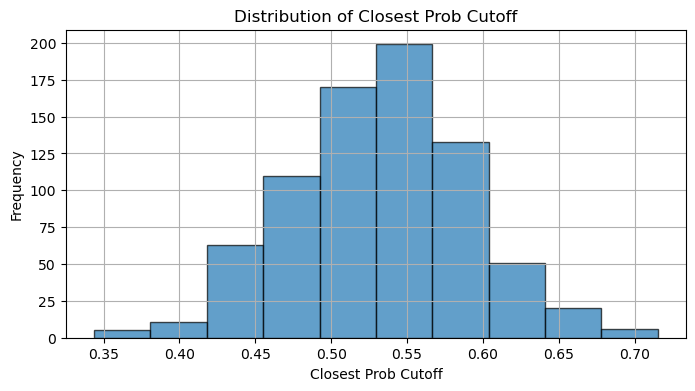

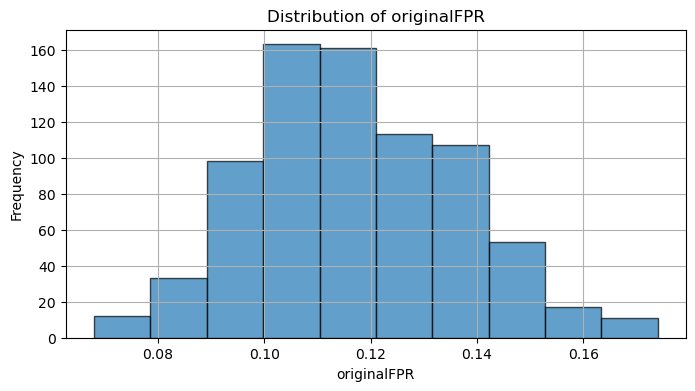

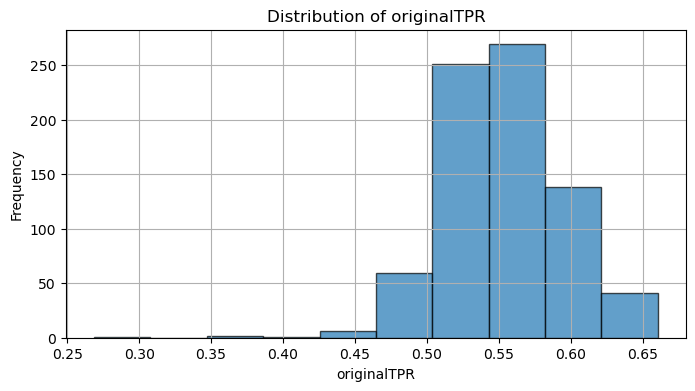

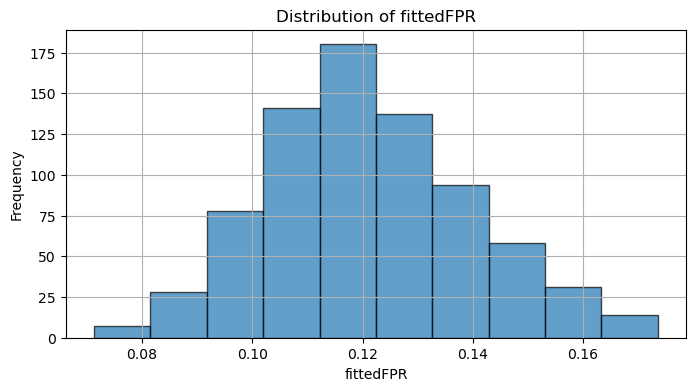

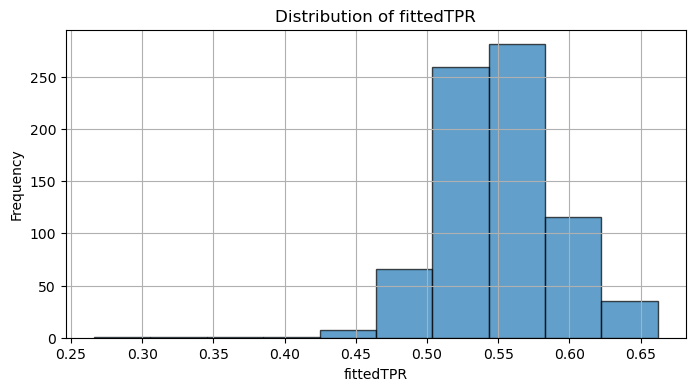

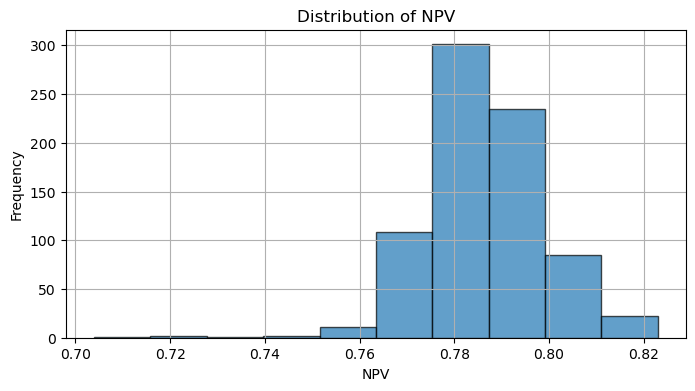

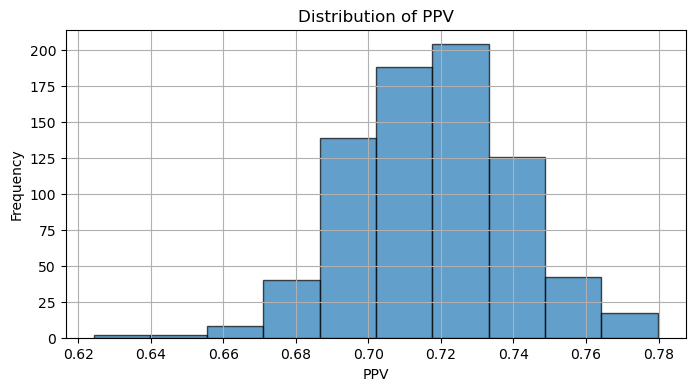

In [24]:
columns = results_df.columns
for column in columns:
    plt.figure(figsize=(8, 4))
    plt.hist(results_df[column], bins=10, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [26]:
# Compute the percentiles
percentiles = compute_percentiles(results_df)
print(percentiles)
#get mean expected utility

                   Closest Prob Cutoff  originalFPR  originalTPR  fittedFPR  \
2.5th Percentile              0.420704        0.084     0.477612   0.088199   
97.5th Percentile             0.647093        0.156     0.634328   0.161040   

                   fittedTPR       NPV       PPV  
2.5th Percentile    0.473407  0.764345  0.677981  
97.5th Percentile   0.631845  0.812555  0.762384  


In [27]:
results_df.mean()

Closest Prob Cutoff    0.531583
originalFPR            0.117172
originalTPR            0.551743
fittedFPR              0.121186
fittedTPR              0.549734
NPV                    0.786490
PPV                    0.717851
dtype: float64